# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [2]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [3]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [4]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [5]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [6]:
# Check the result:

A @ x - b

array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [7]:
import matplotlib.pyplot as plt

def Jacobi(A, b, n_iter):
    n = np.shape(A)[0]
    diag_1d = np.diag(A)
    B = -A.copy()
    np.fill_diagonal(B, 0)
    D = np.diag(diag_1d)
    invD = np.diag(1. / diag_1d)
    BB = invD @ B 
    assert (np.linalg.norm(BB)<1), 'матрица не диагональнодоминирующая' 
    c = invD @ b 
    x = np.ones(n)
    for _ in range(n_iter):
        x = BB @ x + c
    return x

Диагональнодоминирующая

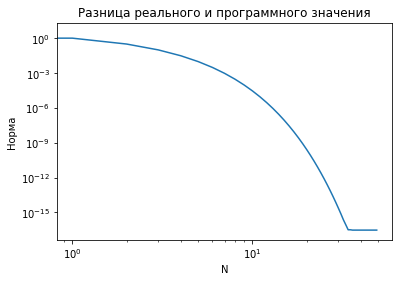

In [17]:
A0 = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b0 = rndm.uniform(size=n)

ind = np.arange(50)
my = []
x_true = np.linalg.solve(A0, b0)
for i in ind:
    my.append(np.linalg.norm(Jacobi(A0, b0, i) - x_true))
plt.plot(ind, my)
plt.title('Разница реального и программного значения')
plt.xlabel('N')
plt.ylabel('Норма')
plt.yscale('log')
plt.xscale('log')

сходимся к машинному нулю

Теперь не диагональнодоминирующая

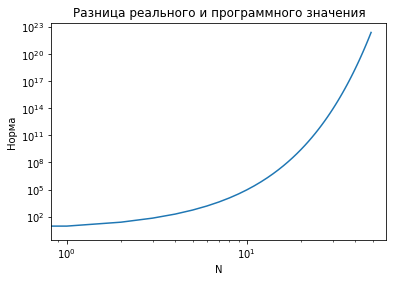

In [18]:
A0 = rndm.uniform(size=(n, n)) + np.diagflat([1]*n)
b0 = rndm.uniform(size=n)

def Jacobi2(A, b, n_iter):
    n = np.shape(A)[0]
    diag_1d = np.diag(A)
    B = -A.copy()
    np.fill_diagonal(B, 0)
    D = np.diag(diag_1d)
    invD = np.diag(1. / diag_1d)
    BB = invD @ B 
    c = invD @ b 
    x = np.ones(n)
    for _ in range(n_iter):
        x = BB @ x + c
    return x
ind = np.arange(50)
my = []
x_true = np.linalg.solve(A0, b0)
for i in ind:
    my.append(np.linalg.norm(Jacobi2(A0, b0, i)-x_true))
plt.plot(ind, my)
plt.title('Разница реального и программного значения')
plt.xlabel('N')
plt.ylabel('Норма')
plt.yscale('log')
plt.xscale('log')

Расходится

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [10]:
def Seidel(A, b, n_it):
    n = np.shape(A)[0]
    x = np.ones(n)
    for _ in range(n_it):
        for i in range(n):
            x[i] = (sum((A[i] != A[i][i]) * A[i] * x) * (-1) + b[i]) / A[i][i]
    return x

Проведем аналогичные тесты

0.28520574190232967


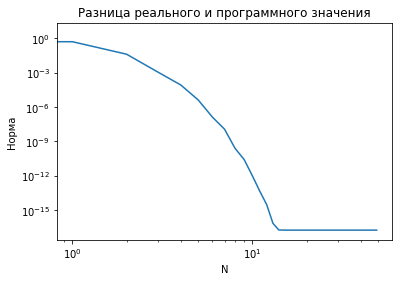

In [19]:
A0 = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b0 = rndm.uniform(size=n)


ind = np.arange(50)
my = []
x_true = np.linalg.solve(A0, b0)

for i in ind:
    my.append(np.linalg.norm(Seidel(A0, b0, i)-x_true))
    
plt.plot(ind, my)
n = np.shape(A)[0]
LD = [[A0[i][j] if i <= j else 0 for i in range(n)] for j in range(n)] 
U = A0 - LD
LD = np.linalg.inv(LD)
plt.title('Разница реального и программного значения')
plt.xlabel('N')
plt.ylabel('Норма')
plt.yscale('log')
plt.xscale('log')
print(np.linalg.norm(LD @ U))

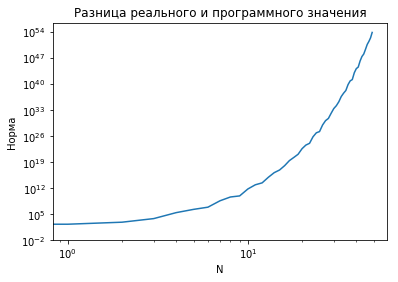

In [20]:
A0 = rndm.uniform(size=(n, n))
b0 = rndm.uniform(size=n)

my = []
x_true = np.linalg.solve(A0, b0)

for i in ind:
    my.append(np.linalg.norm(Seidel(A0, b0, i)-x_true))
    
plt.plot(ind, my)
n = np.shape(A0)[0]
plt.title('Разница реального и программного значения')
plt.xlabel('N')
plt.ylabel('Норма')
plt.yscale('log')
plt.xscale('log')

Для 1 случая все сходится, во 2 случае как и ожидалось все разошлось

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [21]:
def min_res(A, b, n_it):
    x = np.ones(np.shape(A)[0])
    for _ in range(n_it):
        r = A @ x - b
        if np.linalg.norm(A @ r) < 1e-45:
            return x
        tau = np.dot(r, A @ r) / np.linalg.norm(A @ r)**2
        x = x - tau * r 
    return x

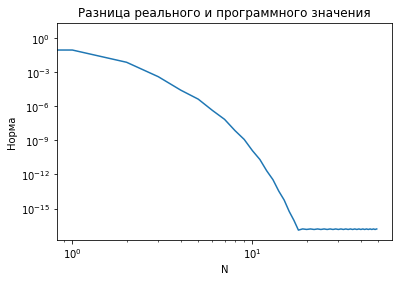

In [22]:
mr_sol = []
x_true = np.linalg.solve(Ad, b0)
for i in ind:
    mr_sol.append(np.linalg.norm(min_res(Ad, b0, i)- x_true)) 
plt.plot(ind, mr_sol,'-')
plt.title('Разница реального и программного значения')
plt.xlabel('N')
plt.ylabel('Норма')
plt.yscale('log')
plt.xscale('log')

Сошлось